In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import Qobj, destroy, variance, coherent, squeeze
from scipy.optimize import minimize

In [2]:
# Auxiliary function used to minimize the nonlinear variance of cubic squeezing
def nlsqpa_v0(l,par):
    l = l[0]
    stav = par[0]
    dim = par[1]
    A = destroy(dim)
    x = (A.dag()+A)/np.sqrt(2)
    p = 1j*(A.dag()-A)/np.sqrt(2)
    return variance(l*p - x**2 / np.sqrt(2)/l**2,stav)/(3/4)

# Function that outputs the value of cubic nonlinear squeezing
def nlsq_v0(stav,dim):
    return minimize(nlsqpa_v0,1.13,args=[stav,dim]).fun

# Functions generating theoretical pure photon-added coherent states
def simulate_spacs(ampl,N):
    a = destroy(N)
    psi = a.dag()*coherent(N, ampl) # Coherent photon addition
    psi = psi.unit() # State vector normalization
    rho = psi * psi.dag() # Making a density matrix out ouf the state psi
    rho = rho[:] # Returning density matrix as an numpy array not Qobj
    return rho

def simulate_tpacs(ampl,N):
    a = destroy(N)
    psi = a.dag()*a.dag()*coherent(N, ampl) # Coherent photon addition
    psi = psi.unit() # State vector normalization
    rho = psi * psi.dag() # Making a density matrix out ouf the state psi
    rho = rho[:] # Returning density matrix as an numpy array not Qobj
    return rho

In [51]:
# Initial guess of s and t
init_params = [1.25,-0.2,0,0,0,0,0]

d = 100
A = destroy(d)
x = (A.dag()+A)/np.sqrt(2)
p = 1j*(A.dag()-A)/np.sqrt(2)

n = A.dag()*A
def R(fli):
    return (-1j*fli*n).expm()
def Dx(alpha):
    return (1j*alpha*p).expm()
def Dp(alpha):
    return (1j*alpha*x).expm()

# Analytical Gaussian benchmark
def varO2(XX,args):
    sr,fli,u = XX
    s,t = args
    AA = 1/2*( np.cos(fli)**2*np.exp(2*sr) + np.sin(fli)**2*np.exp(-2*sr) )
    B = 1/2*( np.cos(fli)**2*np.exp(-2*sr) + np.sin(fli)**2*np.exp(2*sr) )
    C = 1/2*np.cos(fli)*np.sin(fli) * (np.exp(-2*sr) - np.exp(2*sr))
    ret = 16*AA*t**2*u**6+(168*AA**2*t**2+16*AA*s*t)*u**4+\
            2*(4*C*t*u**3+(12*AA*C*t+2*C*s)*u)+(384*AA**3*t**2+72*AA**2*s*t+4*AA*s**2)*u**2+\
            96*AA**4*t**2+24*AA**3*s*t+2*AA**2*s**2+B
    return ret

# Function searching for minimal benchmark over s and t
def BenchmarkN2(s,t):
    return minimize(varO2,[0.1,0.6,0.5],args=[s,t]).fun

# Variance of the quintic operator
def varr(s,t,stav):
    return variance(p + s*x**2 + t*x**4,stav)

# Auxiliary function used to minimize the nonlinear variance of quintic squeezing 
def newxi(xx,pars):
    s,t,fli0,fli,dx,dp,k = xx
    stav = pars[0]
    dim = len(stav[:])
    rho = (Qobj(np.pad(stav,(0,d-dim), 'constant', constant_values=(0,0)))).unit()
    rot = R(fli)
    rot0 = R(fli0)
    dispx = Dx(dx)
    dispp = Dp(dp)
    rhoa = dispx*dispp*rot*squeeze(d,k)*rot0*rho*rot0.dag()*squeeze(d,k).dag()*rot.dag()*dispp.dag()*dispx.dag()
    
    return np.real(varr(s,t,rhoa))/BenchmarkN2(s,t)

#Function that outputs the value of quintic nonlinear squeezing
def xi(stav):
    res = minimize(newxi,init_params,args=[stav],method = "SLSQP")
    return res

In [4]:
# Data to be plotted
amplitude_tpacs = np.array([1.2094494296716143, 1.0481857558557053, 1.3881750772611334, 0.8385418541396282])
cubic_nlsqs_tpacs = [0.7683992888963331, 0.8333026952140088, 1.0662222809404416, 1.355433456049968]
cubic_nlsqs_err_tpacs = [0.116,0.166,0.155,0.224]
quintic_nlsqs_tpacs = [0.758,0.83329,1.0457,0.9685]
quintic_nlsqs_err_tpacs = [0.121,0.166,0.180,0.226]

amplitude_spacs = np.array([0.60382857820543, 0.7829442161976218, 0.9819268739639597, 1.2410978792122727, 1.431436731069673, 1.350031630110495])
cubic_nlsqs_spacs = [1.557,1.062,0.864,0.812,0.735,0.762]
cubic_nlsqs_err_spacs = [0.12,0.096,0.078,0.077,0.051,0.072]
quintic_nlsqs_spacs = [1.414,1.0116,0.864,0.812,0.6971,0.762]
quintic_nlsqs_err_spacs = [0.087,0.086,0.08,0.077,0.057,0.072]

In [5]:
# Calculation of theoretical curves for cubic nonlinear squeezing
dim = 25
cubic_alphas = np.round(np.arange(0.45,2.05,0.01),2)
quintic_alphas = np.round(np.arange(0.45,2.05,0.05),2)

List_of_tpacs_cubic = [nlsq_v0(Qobj(simulate_tpacs(-alpha*1j,N=dim)),dim) for alpha in cubic_alphas]
List_of_tpacs_cubic = np.array(List_of_tpacs_cubic)

List_of_spacs_cubic = [nlsq_v0(Qobj(simulate_spacs(-alpha*1j,N=dim)),dim) for alpha in cubic_alphas]
List_of_spacs_cubic = np.array(List_of_spacs_cubic)

In [6]:
# Calculation of theoretical curve for quintic nonlinear squeezing of SPACs
dim = 100

List_of_alphas = []

List_of_spacs_quintic = []

for alpha in quintic_alphas:
    try:
        List_of_spacs_quintic.append(xi(simulate_spacs(alpha*1j,N=dim)).fun)
        List_of_alphas.append(alpha)
    except:
        continue

List_of_spacs_quintic = np.array(List_of_spacs_quintic)

In [52]:
# Calculation of theoretical curve for quintic nonlinear squeezing of TPACs
dim = 100

# Auxiliary list
List_of_states_tpacs = []
List_of_params_tpacs = []

for alpha in quintic_alphas:
    try:
        res = xi(simulate_tpacs(alpha*1j,N=dim))
        List_of_states_tpacs.append(res.fun)
        List_of_params_tpacs.append(res.x)
    except Exception as e:
        raise Exception('Something went wrong',e)
        continue
        
# Auxiliary array
List_of_states_tpacs = np.array(List_of_states_tpacs)

indexes = []

# For the sake of time we sample theoretical curves of quintic 
for number in quintic_alphas:
    try:
        idx = np.where(cubic_alphas == number)[0][0]
        indexes.append(idx)
    except:
        print(f"Amplitude {number} not found.")
        continue
#indexes.append(154)

List_of_tpacs_quintic = []

# In case the algorithm fails to minimize the value of quintic 
for i in range(len(List_of_states_tpacs)):
    if List_of_states_tpacs[i] > List_of_tpacs_cubic[indexes[i]]:
        List_of_tpacs_quintic.append(List_of_tpacs_cubic[indexes[i]])
    else:
        List_of_tpacs_quintic.append(List_of_states_tpacs[i])

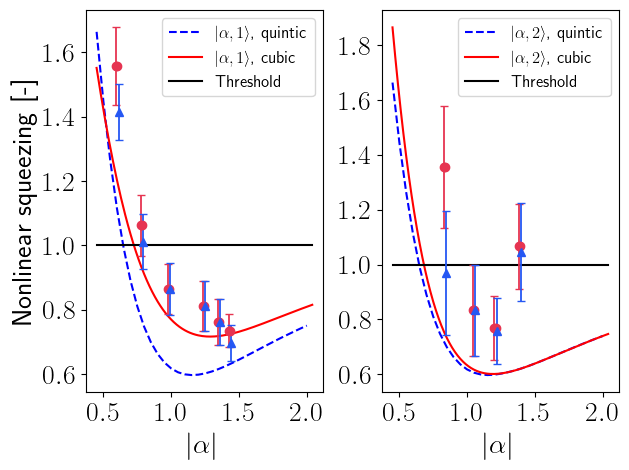

In [57]:
fontsize = 20
labelfontsize = 12
filename = "Figure 5"
plt.rcParams['text.usetex'] = True

color2=(230/255,52/255,81/255,1)
color6=(37/255,87/255,243/255,1)
c1=color2
c2=color6
plt.subplot(1,2,1)
#%matplotlib notebook

plt.plot(quintic_alphas,List_of_states_tpacs,'b--',label = r"$|\alpha,1\rangle$, quintic")
#plt.plot(quintic_alphas,List_of_spacs_quintic,'b--',label = r"$|\alpha,1\rangle$, quintic")
plt.plot(cubic_alphas,List_of_spacs_cubic,'r-',label = r"$|\alpha,1\rangle$, cubic")
plt.plot(cubic_alphas,np.ones(len(cubic_alphas)),"k-",label = "Threshold")
plt.errorbar(amplitude_spacs - 0.008,cubic_nlsqs_spacs, yerr = cubic_nlsqs_err_spacs,fmt ='o',color=c1, elinewidth=1.3, capsize=3)
plt.errorbar(amplitude_spacs + 0.008,quintic_nlsqs_spacs, yerr = quintic_nlsqs_err_spacs,fmt ='^',color=c2, elinewidth=1.3, capsize=3)
plt.plot(amplitude_spacs,cubic_nlsqs_spacs,'o',color=c1)#,label = "Measured SPACs")
plt.xlabel(r'$\vert \alpha \vert$',fontsize = fontsize)
plt.ylabel('Nonlinear squeezing [-]',fontsize = fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize = labelfontsize)


plt.subplot(1,2,2)
plt.plot(quintic_alphas,List_of_tpacs_quintic,'b--',label = r"$|\alpha,2\rangle$, quintic")
plt.plot(cubic_alphas,List_of_tpacs_cubic,'r-',label = r"$|\alpha,2\rangle$, cubic")
plt.plot(cubic_alphas,np.ones(len(cubic_alphas)),"k-",label = "Threshold")
plt.errorbar(amplitude_tpacs - 0.008,cubic_nlsqs_tpacs, yerr = cubic_nlsqs_err_tpacs,fmt ='o',color=c1, elinewidth=1.3, capsize=3)
plt.errorbar(amplitude_tpacs + 0.008,quintic_nlsqs_tpacs, yerr = quintic_nlsqs_err_tpacs,fmt ='^',color=c2, elinewidth=1.3, capsize=3)
plt.plot(amplitude_tpacs,cubic_nlsqs_tpacs,'o',color=c1)#,label = "Measured TPACs")
plt.xlabel(r'$\vert \alpha \vert$',fontsize = fontsize)
#plt.ylabel('Nonlinear squeezing [-]',fontsize = fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize = labelfontsize)

plt.tight_layout()
#plt.savefig(f"{filename}.png", dpi=300, bbox_inches = 'tight')
#plt.savefig(f"{filename}.pdf", dpi=300, bbox_inches = 'tight')